In [1]:
import numpy as np
import pandas as pd
from gurobipy import *

# load symposia data
symposia      = pd.read_csv('symposia_report_with_all_speakers.csv', header=0)
panel_titles  = [np.asarray(symposia[symposia['Poster No'] == k]['Abstract Title'])[0] for k in pd.unique(symposia['Poster No'])]
timeslotsList = ['Day1_morning','Day1_afternoon','Day2_morning','Day2_afternoon',
                 'Day3_morning','Day3_afternoon','Day4_morning']
symp_per_slot = [4,3,4,4,4,3,4]               # symposia per time slot; modify as needed
room_names    = ['Room 1','Room 2','Room 3','Room 4']
rooms         = [200,200,300,1000]            # room capacity
sim_mat_file  = 'sim_mat_panels.npy'          # load similarity matrix of overlapping coauthorship across symposia

ns            = len(panel_titles)             # number of symposia
nt            = len(timeslotsList)            # number of time slots
nr            = len(rooms)                    # number of rooms
# symp_per_slot = np.int(ns/nt)                 # uncomment if consistent number across time slots
# sim_mat       = sim_mat[:ns,:ns]              # uncomment if not using all symposia (select first ns symposia)

# Manual constrain functions:
def load_sim_mat(filename):
    sim_mat   = np.load(filename) # load similarity matrix of overlapping coauthorship across symposia
    return sim_mat

# add constraints for specific symposia that are already scheduled, eg:
def scheduleSymposia(a,b):
    m.addConstr(x[a,b] == 1) # lock symposium a in list to time slot b
    print('Lock: \"' + panel_titles[a] + '\" to ' + timeslotsList[b])

# prioritize symposia earlier in conference
def prioritizeScheduling(a):
    for c in range(int(nt/2),nt): # put symposium in first half of conference 
        m.addConstr(x[a,c] == 0)
    print('Prioritize: \"' + panel_titles[a] + '\"')
    
# constrain specific symposia to not be in same time slot, eg:
def avoidSymposiaOverlap(a,b):
    for j in range(nt):
        m.addConstr(y[a,b,j] == 0)
        m.addConstr(y[b,a,j] == 0)
        sim_mat[a,b]=1
        sim_mat[b,a]=1
    print('Don\'t overlap: \"' + panel_titles[a] + '\" with \"' + panel_titles[b] + '\"')
    
# schedule specific symposia together, eg:
def symposiaOverlap(a,b):
    m.addConstr(quicksum(y[a,b,j] for j in range(nt)) == 1)
    m.addConstr(quicksum(y[b,a,j] for j in range(nt)) == 1)
    sim_mat[a,b]=0
    sim_mat[b,a]=0
    print('Schedule together: \"' + panel_titles[a] + '\" and \"' + panel_titles[b] + '\"')

# assign rooms
def assignRooms(a,size):
    # options for size: 'large', 'medium', 'small'
    if size == 'large':
        room_id = np.argmax(rooms)
    if size == 'medium':
        room_id = np.argsort(rooms)[int(len(rooms)/2)]
    if size == 'small':
        room_id = np.argmin(rooms)
    m.addConstr(z[a,room_id] == 1) # assign to largest rooms
    print('Room assignment: \"' + panel_titles[a] + '\" in \"' + room_names[room_id] + '\"')
    
# print IDs for symposia titles and time slots
print('Rooms:')
for i,n in enumerate(room_names):
    print('%s capacity: %i' % (n,rooms[i]))
print('')    
print('Time slots:')
for i,n in enumerate(timeslotsList):
    print('%i: %s' % (i,n))
print('')    
print('Symposia titles:')
for i,n in enumerate(panel_titles):
    print('%i: %s' % (i,n))

Rooms:
Room 1 capacity: 200
Room 2 capacity: 200
Room 3 capacity: 300
Room 4 capacity: 1000

Time slots:
0: Day1_morning
1: Day1_afternoon
2: Day2_morning
3: Day2_afternoon
4: Day3_morning
5: Day3_afternoon
6: Day4_morning

Symposia titles:
0: Heterogeneity in Neurodevelopmental Disorders: Identification, Nosology, and Intervention
1: Neurovascular Coupling in Health and Disease: Revisiting the Hemodynamic Response Function
2: Neuropsychiatric genetic variation shapes brain architecture by modulating gene expression
3: Neurodevelopmental insights from fetal and infant imaging
4: OHBM-DGKN Alliance: International Symposium on Stroke Recovery
5: Discerning signal from artifact: Current Issues in resting-state fMRI quality control
6: Two is better than one (and many are better): Multi-echo fMRI methods and applications
7: Measuring the Individual: Understanding sources of variability in task and resting fMRI
8: Approaches and Challenges for Across-Site Harmonization of Structural, Functio

Using license file /Users/dmargulies/gurobi.lic
Academic license - for non-commercial use only
Lock: "OHBM-DGKN Alliance: International Symposium on Stroke Recovery" to Day3_afternoon
Lock: "Diversity Round Table: Neuroscience and the LGBTQ Community" to Day1_afternoon
Prioritize: "A tale of parcels & gradients: individual differences & behavioral associations"
Prioritize: "What can Modern Bayesian Methods Offer Neuroimaging Data Analysis?"
Don't overlap: "Two is better than one (and many are better): Multi-echo fMRI methods and applications" with "Big Data & Machine Learning Personalize Neuropsychiatric Disorders–Ready for Clinical Translation?"
Don't overlap: "Two is better than one (and many are better): Multi-echo fMRI methods and applications" with "Neurovascular Coupling in Health and Disease: Revisiting the Hemodynamic Response Function"
Schedule together: "A global perspective on the neural bases of intelligence" and "A tale of parcels & gradients: individual differences & beha

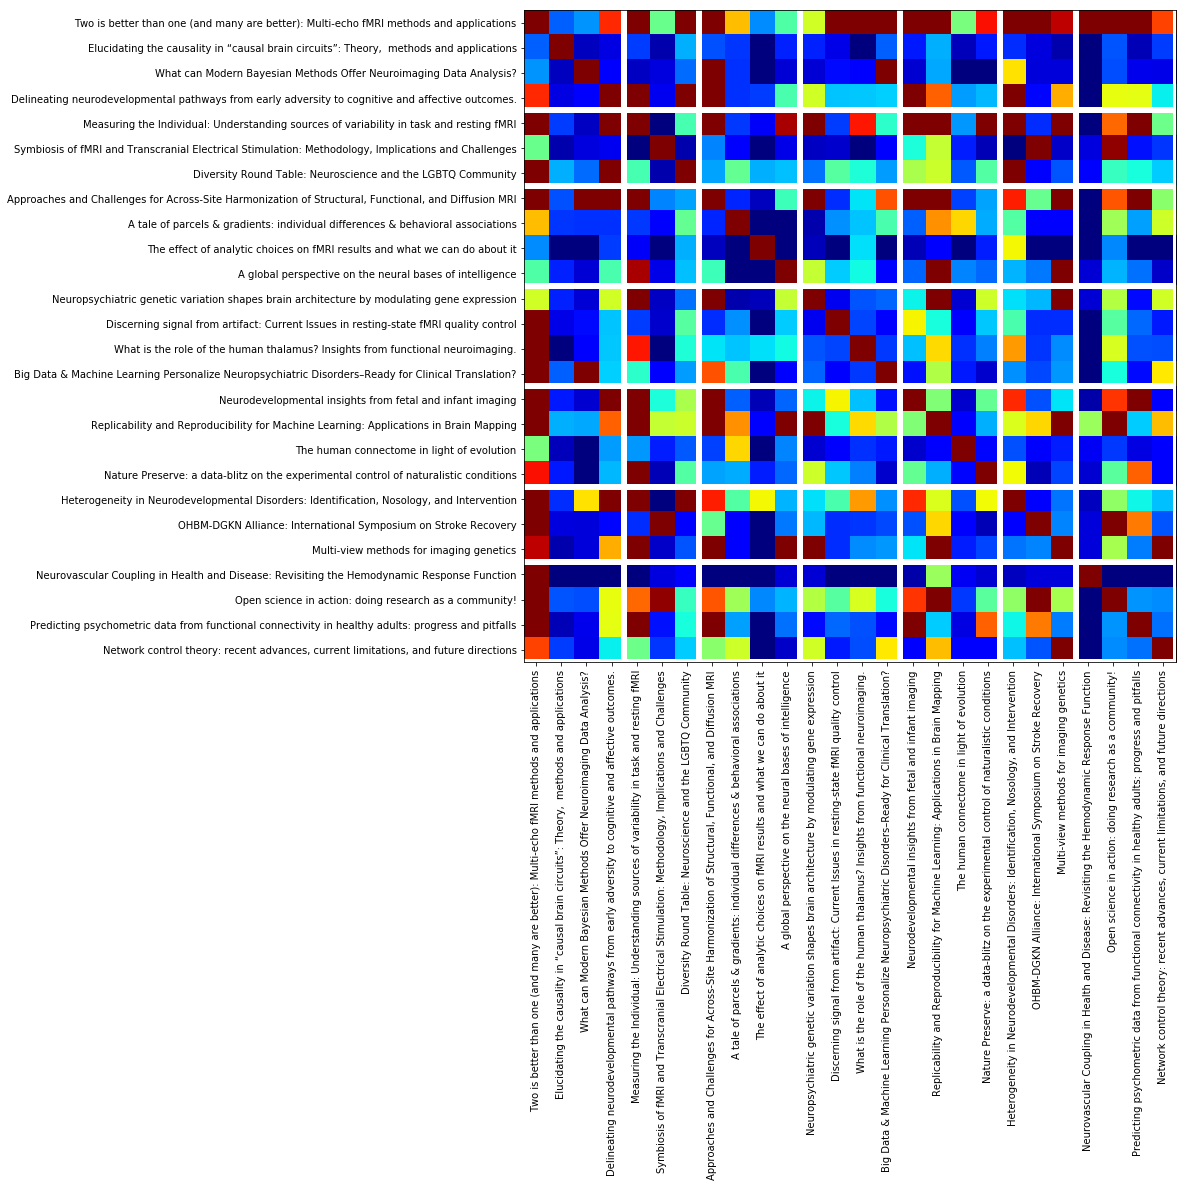

In [2]:
m = Model("Symposia")                # initiate model
sim_mat = load_sim_mat(sim_mat_file) # load similarity matrix

# add variables 
x = m.addVars(range(ns),range(nt),vtype=GRB.BINARY,name='x')           # symposia x time slots 
z = m.addVars(range(ns),range(nr),vtype=GRB.BINARY,name='z')           # symposia x rooms
y = m.addVars(range(ns),range(ns),range(nt),vtype=GRB.BINARY,name='y') # symposia x symposia x time slots

# example specifications:
scheduleSymposia(4,5)      # lock symposia 1 to time slot 1
scheduleSymposia(19,1)
prioritizeScheduling(9)    # schedule symposia in first half of conference
prioritizeScheduling(14)
avoidSymposiaOverlap(6,20) # avoid overlap
avoidSymposiaOverlap(6,1)
symposiaOverlap(23,9)      # force overlap
assignRooms(4,'large')     # assign rooms
assignRooms(20,'small')

# add variables for weighting parallel symposia by similarity matrix
i_pairs_list = list(itertools.combinations(range(ns),2))
for i,ip in i_pairs_list: # loop through i and ip, where i != ip
    for j in range(nt):
        m.addConstr(x[i,j] + x[ip,j] - y[i,ip,j] <= 1)
        m.addConstr(2*y[i,ip,j] - x[i,j] - x[ip,j] <= 0)

# Room scheduling
for j in range(nt):
    for r in range(nr):
        m.addConstr(quicksum([x[s,j] * z[s,r] for s in range(ns)]) <= 1)
m.addConstrs(z.sum(s,'*') == 1 for s in range(ns))                  # only place symposium once in a room
m.addConstrs(z.sum('*',r) <= len(symp_per_slot) for r in range(nr)) # each room holds max of len(timeslots) symposia
m.addConstrs(x.sum(s,'*') == 1 for s in range(ns))                  # only hold symposium once
m.addConstrs(x.sum('*',t) == symp_per_slot[t] for t in range(nt))   # constrain number of symposia per time slot

cost = quicksum(quicksum(sim_mat[i,ip]*y[i,ip,j] 
                         for i,ip in i_pairs_list) for j in range(nt)) # cost minimizes sum(similarity matrix weights)

m.setObjective(cost, GRB.MINIMIZE)
m.update()
print('')
m.optimize()

##################################################################################################
# Run checks:
##################################################################################################
verbose = False     # set to True to print matrix
verbose_plot = True # display similarity matrix

# check time slots
res_all = [np.int(r) for r in m.X[:ns*nt]]
res = np.reshape(res_all,(ns,nt))
dashboard_schedule = pd.DataFrame(data = res,columns = range(nt), index = range(ns))

print('===== scheduling checks: =====')
print('symposia per timeslot: ' + str(np.sum(res,axis=0)))
print('slots per symposia: ' + str(np.sum(res,axis=1)))
if verbose:
    print(dashboard_schedule)

# check rooms
res_rooms = []
for n,i in enumerate(m.VarName):
    if 'z[' in i:
        res_rooms.append(int(m.X[n]))
        
res_rooms = np.reshape(res_rooms,(ns,nr))
dashboard_rooms = pd.DataFrame(data = res_rooms, columns = range(nr), index = range(ns))

print('')
print('===== Room checks: =====')
print('symposia per room: ' + str(np.sum(res_rooms,axis=0)))
print('rooms per symposia: ' + str(np.sum(res_rooms,axis=1)))
if verbose:
    print(dashboard_rooms)

print('')
print('===== Schedule: ======')
for s in list(range(nt)):
    print(timeslotsList[s])
    for i in dashboard_schedule[dashboard_schedule[s] == 1].loc[:,].index:
        room_ind = int(np.where(dashboard_rooms.loc[i] == 1)[0])
        print(room_names[room_ind]  + ': ' + panel_titles[i])
    print('')

if verbose_plot:
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm

    newOrder = np.zeros(ns, dtype=np.int)
    count = 0
    for s in list(range(nt)):
        for r in dashboard_schedule[dashboard_schedule[s] == 1].loc[:,].index:
            newOrder[count] = r
            count += 1
    panel_titles_reordered = [panel_titles[i] for i in newOrder]

    fig = plt.figure(figsize=(12,12))
    plt.imshow(sim_mat[:,newOrder][newOrder].squeeze(), interpolation='nearest', cmap=cm.jet, vmax=0.05)
    ax = plt.gca()
    ax.set_yticks(np.arange(0, len(panel_titles_reordered), 1))
    ax.set_xticks(np.arange(0, len(panel_titles_reordered), 1))
    ax.set_yticklabels(panel_titles_reordered)
    ax.set_xticklabels(panel_titles_reordered)
    plt.xticks(rotation=90)

    for i in np.cumsum(list(np.asarray(symp_per_slot)))-0.5:
        plt.axvline(x=i, color='white', linewidth=6)
        plt.axhline(y=i, color='white', linewidth=6)

    plt.show()

    # squares along diagonal reflext similarity of symposia sessions: